In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch.autograd.functional import jacobian, hessian
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import re 
import plotly.express as px



## Parameters and Basic settings

In [50]:
E = 0.032
nu = 0.4
G = E/(2*(1+nu))
#Force = 1.
seed_id = 1234
lr = 1e-2
nneurons = 20
nhiden_layers = 4
#Nf_x = 50 # Number of collocation points in x direction
#Nf_y = 20 # Number of collocation points in y direction
#N_bc = 30 # Number of boundary points

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print(torch.cuda.get_device_name(device))

# Set default dtype to float32
torch.set_default_dtype(torch.float32)
# PyTorch random number generator
torch.manual_seed(seed_id)
# Random number generators in other libraries
np.random.seed(seed_id)

Using device: cuda
NVIDIA A2


## Normalization

In [51]:
def normalize(X_tensor, X_min, X_max):
    """
    Normalize a tensor by columns given a max and min of each column.
    
    Parameters:
    X_tensor(numpy array): Tensor to be normalized.
    """
    # Normalize input vector X by each feature
    (num_row_X, num_col_X) = X_tensor.shape
    normalized_X_tensor = torch.zeros_like(X_tensor)
    
    # Fill the copy vector
    for col in range(num_col_X):
        min_X_col = X_min[col]
        max_X_col = X_max[col]
        normalized_X_tensor[:,col] = (X_tensor[:,col]-min_X_col)/(max_X_col-min_X_col)#(X_tensor[:,col]-min_X_col)*2/(max_X_col-min_X_col)# -1 #para que es este -1?  
        
    return normalized_X_tensor

def unnormalize(X_tensor, X_min, X_max):
    """
    Unnormalize a tensor by columns given a max and min of each column.
    
    Parameters:
    X_tensor(numpy array): Tensor to be unnormalized.
    X_max(numpy array): Max of each column of the tensor to be unnormalized.
    X_min(numpy array): Min of each column of the tensor to be unnormalized.
    """
    # Unnormalize input vector X by each feature
    (num_row_X, num_col_X) = X_tensor.shape
    unnormalized_X_tensor = torch.zeros_like(X_tensor)
    
    # Fill the copy vector
    for col in range(num_col_X):
        unnormalized_X_tensor[:,col] = (X_tensor[:,col])*(X_max[col]-X_min[col]) + X_min[col]#(X_tensor[:,col]+1)*(X_max[col]-X_min[col])/2 + X_min[col]
        
    return unnormalized_X_tensor

## Loading data SOL1

In [52]:
def keep_line(line):
    line_split=line.split()
    try:
        int(line_split[0])
        #si no dio error, okey entra
        return True
    except:
        return False

In [53]:
#posicion inicial de los nodos 

ititialPosition_data_path = "./data/ARTURO_TEST_1/NODES.txt"

with open(ititialPosition_data_path,"r") as f:
    aux_list=f.readlines()

ititialPosition_data=[i for i in aux_list if keep_line(i)]
ititialPosition_data=[i.strip("\n") for i in ititialPosition_data]
ititialPosition_data=[i.split() for i in ititialPosition_data]
ititialPosition_data_np=np.array(ititialPosition_data).astype(float)[:,[0,1,2,3]]
ititialPosition_data_pd=pd.DataFrame(ititialPosition_data_np,columns=["Node","X","Y","Z"]).set_index("Node")
ititialPosition_data_pd

,X,Y,Z
Node,,,
1.0,46.726,41.840,17.459
2.0,31.149,44.342,17.410
3.0,54.619,26.576,39.528
4.0,63.720,39.982,42.026
5.0,19.543,50.820,41.746
...,...,...,...
4147.0,47.957,36.969,40.653
4148.0,43.244,36.666,35.819
4149.0,46.140,37.853,37.430


In [54]:
#cargar datos de stress

stress_data_path = "./data/LINEAR_SMALL_DISP/PSOL_1_NODAL_STRESSES.txt"

with open(stress_data_path,"r") as f:
    aux_list=f.readlines()


stress_data=[i for i in aux_list if keep_line(i)]
stress_data=[i.strip("\n").strip() for i in stress_data]
patron = "[-.\d]+E-*\d{3}|^\d{0,4}|0\.0000"

stress_data=[re.findall(patron,i) for i in stress_data]
stress_data=np.array(stress_data,dtype=float)
stress_data=pd.DataFrame(stress_data,columns=["Node","SX","SY","SZ","SXY","SYZ","SXZ"]).set_index("Node")
stress_data

,SX,SY,SZ,SXY,SYZ,SXZ
Node,,,,,,
1.0,6.359800e-05,-9.768900e-05,0.000006,5.814800e-05,0.000016,0.000028
2.0,5.329900e-05,-1.960100e-04,0.000017,-7.025600e-05,0.000009,-0.000028
3.0,-6.827400e-05,-1.899300e-04,-0.000049,1.077600e-05,-0.000006,-0.000034
4.0,1.553200e-05,4.620800e-06,0.000015,-1.085300e-05,-0.000069,0.000009
5.0,-3.259900e-05,-6.732900e-05,0.000396,-1.020500e-04,-0.000173,-0.000088
...,...,...,...,...,...,...
1670.0,-5.268200e-06,-6.619700e-06,0.000055,6.783100e-06,-0.000046,0.000015
1671.0,-7.030200e-07,7.580400e-07,0.000038,5.192500e-06,-0.000039,-0.000005
1672.0,-7.150100e-06,-7.083100e-06,0.000039,2.970400e-07,-0.000062,0.000023


In [55]:
# cargar datos de desplazamiento  
displacement_data_path = "./data/LINEAR_SMALL_DISP/PSOL_2_NODAL_DISP.txt"

with open(displacement_data_path,"r") as f:
    aux_list=f.readlines()


displacement_data=[i for i in aux_list if keep_line(i)]
displacement_data=[i.strip("\n").strip() for i in displacement_data]
patron = r"[-.\d]+E-*\d{3}|^\d{0,4}|-?\d+\.\d+|0\.0000"

displacement_data=[re.findall(patron,i) for i in displacement_data]

In [56]:

displacement_data=np.array(displacement_data,dtype=float)
displacement_data=pd.DataFrame(displacement_data,columns=["Node","UX","UY","UZ","USUM"]).set_index("Node")
displacement_data

,UX,UY,UZ,USUM
Node,,,,
1.0,0.076719,-0.329060,-0.103990,0.353530
2.0,-0.063502,-0.388420,-0.136950,0.416720
3.0,0.039542,0.000000,0.017036,0.043056
4.0,0.042579,-0.043482,-0.019361,0.063863
5.0,-0.028556,-0.089468,0.050299,0.106540
...,...,...,...,...
4147.0,0.045424,-0.128460,0.076083,0.156060
4148.0,0.019351,-0.151880,0.041223,0.158560
4149.0,0.031225,-0.150200,0.054370,0.162760


In [57]:
# cargar datos de boundaries en el movimiento
#cargar los nodos fijos
with open("./data/ARTURO_TEST_1/RESTRINGED_NODES.txt","r") as f:
    restricted_data=f.readlines()

restricted_data=[i for i in restricted_data if keep_line(i)]
restricted_data=[i.strip("\n") for i in restricted_data]
restricted_data=[i.split() for i in restricted_data]
restricted_data_np=np.array(restricted_data)[:,[0,1]]
restricted_data_pd=pd.DataFrame(restricted_data_np,columns=["Node","Direccion"])
restricted_data_pd=restricted_data_pd.groupby("Node")["Direccion"].apply(lambda x : list(x)).to_frame().sort_index()
restricted_data_pd.index=restricted_data_pd.index.astype(int)
restricted_data_pd=restricted_data_pd.sort_index()
restricted_data_pd=restricted_data_pd.rename(columns={"Direccion":"Restricciones"})
restricted_data_pd

,Restricciones
Node,
3,[UY]
7,[UY]
23,[UY]
24,[UY]
25,[UY]
...,...
3263,"[UX, UY, UZ]"
3264,"[UX, UY, UZ]"
3290,"[UX, UY, UZ]"


Las limitaciones en todas las direcciones las tenemos en los contactos laterales con la cadera. Y la restricción de movimiento en Y, la tenemos en la pared donde se aplica la presión.  

En nuestro caso concreto, esta restricción que se está aplicando sobre los desplazamientos de algunos nodos solo en Y no es en la misma zona donde se está aplicando la fuerza.  


In [58]:
with open("./data/ARTURO_TEST_1/FORCE_ON_NODES.txt","r") as f:
    force_data=f.readlines()


force_data=[i for i in force_data if keep_line(i)]
force_data=[i.strip("\n") for i in force_data]
force_data=[i.split() for i in force_data]
force_data_np=np.array(force_data)[:,[0,1,2]]
force_data_pd=pd.DataFrame(force_data_np,columns=["Node","Direccion_Fuerza","Fuerza"])
force_data_pd["Fuerza"]=force_data_pd["Fuerza"].astype(float)
force_data_pd=force_data_pd.set_index("Node")
force_data_pd.index=force_data_pd.index.astype(int)
force_data_pd

,Direccion_Fuerza,Fuerza
Node,,
6,FY,-0.02
181,FY,-0.02
182,FY,-0.02
183,FY,-0.02
184,FY,-0.02
...,...,...
2568,FY,-0.02
2569,FY,-0.02
2571,FY,-0.02


In [59]:
#ponemos todos los datos en común usando los nodos como clave   
final_data=ititialPosition_data_pd.merge(stress_data,left_index=True,right_index=True,how="left").merge(force_data_pd,left_index=True,right_index=True,how="left").merge(displacement_data,left_index=True,right_index=True,how="left").merge(restricted_data_pd,left_index=True,right_index=True,how="left")
final_data

,X,Y,Z,SX,SY,SZ,SXY,SYZ,SXZ,Direccion_Fuerza,Fuerza,UX,UY,UZ,USUM,Restricciones
Node,,,,,,,,,,,,,,,,
1.0,46.726,41.840,17.459,0.000064,-0.000098,0.000006,0.000058,0.000016,0.000028,NaN,NaN,0.076719,-0.329060,-0.103990,0.353530,NaN
2.0,31.149,44.342,17.410,0.000053,-0.000196,0.000017,-0.000070,0.000009,-0.000028,NaN,NaN,-0.063502,-0.388420,-0.136950,0.416720,NaN
3.0,54.619,26.576,39.528,-0.000068,-0.000190,-0.000049,0.000011,-0.000006,-0.000034,NaN,NaN,0.039542,0.000000,0.017036,0.043056,[UY]
4.0,63.720,39.982,42.026,0.000016,0.000005,0.000015,-0.000011,-0.000069,0.000009,NaN,NaN,0.042579,-0.043482,-0.019361,0.063863,NaN
5.0,19.543,50.820,41.746,-0.000033,-0.000067,0.000396,-0.000102,-0.000173,-0.000088,NaN,NaN,-0.028556,-0.089468,0.050299,0.106540,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147.0,47.957,36.969,40.653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.045424,-0.128460,0.076083,0.156060,NaN
4148.0,43.244,36.666,35.819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019351,-0.151880,0.041223,0.158560,NaN
4149.0,46.140,37.853,37.430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031225,-0.150200,0.054370,0.162760,NaN


In [60]:
final_data.Direccion_Fuerza

Node
1.0       NaN
2.0       NaN
3.0       NaN
4.0       NaN
5.0       NaN
         ... 
4147.0    NaN
4148.0    NaN
4149.0    NaN
4150.0    NaN
4151.0    NaN
Name: Direccion_Fuerza, Length: 4151, dtype: object

In [61]:
final_data.loc[~final_data.Direccion_Fuerza.isna()]

,X,Y,Z,SX,SY,SZ,SXY,SYZ,SXZ,Direccion_Fuerza,Fuerza,UX,UY,UZ,USUM,Restricciones
Node,,,,,,,,,,,,,,,,
6.0,27.108,57.070,47.311,-0.000391,-0.000707,-0.000327,-0.000096,0.000233,-0.000023,FY,-0.02,-0.004515,-0.53111,0.127660,0.54625,NaN
181.0,26.161,50.981,29.122,0.000191,-0.000045,0.000125,-0.000151,0.000043,-0.000082,FY,-0.02,0.000000,0.00000,0.000000,0.00000,"[UX, UY, UZ]"
182.0,26.443,50.288,27.876,0.000128,-0.000281,-0.000004,-0.000260,-0.000025,-0.000114,FY,-0.02,0.000000,0.00000,0.000000,0.00000,"[UX, UY, UZ]"
183.0,27.980,49.724,25.295,-0.000057,-0.000725,0.000154,-0.000230,0.000250,-0.000108,FY,-0.02,0.036269,-0.31607,-0.101380,0.33391,NaN
184.0,27.784,49.479,25.129,-0.000363,-0.001375,-0.000109,-0.000487,0.000149,-0.000128,FY,-0.02,0.021100,-0.29044,-0.096876,0.30690,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568.0,38.621,51.321,30.327,NaN,NaN,NaN,NaN,NaN,NaN,FY,-0.02,0.010023,-0.49442,-0.071319,0.49964,NaN
2569.0,37.562,52.301,32.492,NaN,NaN,NaN,NaN,NaN,NaN,FY,-0.02,0.014496,-0.54291,-0.036191,0.54431,NaN
2571.0,38.862,53.157,34.880,NaN,NaN,NaN,NaN,NaN,NaN,FY,-0.02,0.001520,-0.58766,0.001595,0.58766,NaN


In [62]:
color_aux=[]
for i,j in final_data.iterrows():
    if not np.isnan(j.Fuerza):
        if j.Restricciones==["UY"]:
            color_aux.append(1)
        else:
            color_aux.append(2)
    elif j.Restricciones==["UY"]:
        color_aux.append(3)
    else:
        color_aux.append(4)

In [63]:
final_data["Final_X"]=final_data["X"]-final_data["UX"]
final_data["Final_Y"]=final_data["Y"]-final_data["UY"]
final_data["Final_Z"]=final_data["Z"]-final_data["UZ"]
final_data

,X,Y,Z,SX,SY,SZ,SXY,SYZ,SXZ,Direccion_Fuerza,Fuerza,UX,UY,UZ,USUM,Restricciones,Final_X,Final_Y,Final_Z
Node,,,,,,,,,,,,,,,,,,,
1.0,46.726,41.840,17.459,0.000064,-0.000098,0.000006,0.000058,0.000016,0.000028,NaN,NaN,0.076719,-0.329060,-0.103990,0.353530,NaN,46.649281,42.169060,17.562990
2.0,31.149,44.342,17.410,0.000053,-0.000196,0.000017,-0.000070,0.000009,-0.000028,NaN,NaN,-0.063502,-0.388420,-0.136950,0.416720,NaN,31.212502,44.730420,17.546950
3.0,54.619,26.576,39.528,-0.000068,-0.000190,-0.000049,0.000011,-0.000006,-0.000034,NaN,NaN,0.039542,0.000000,0.017036,0.043056,[UY],54.579458,26.576000,39.510964
4.0,63.720,39.982,42.026,0.000016,0.000005,0.000015,-0.000011,-0.000069,0.000009,NaN,NaN,0.042579,-0.043482,-0.019361,0.063863,NaN,63.677421,40.025482,42.045361
5.0,19.543,50.820,41.746,-0.000033,-0.000067,0.000396,-0.000102,-0.000173,-0.000088,NaN,NaN,-0.028556,-0.089468,0.050299,0.106540,NaN,19.571556,50.909468,41.695701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147.0,47.957,36.969,40.653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.045424,-0.128460,0.076083,0.156060,NaN,47.911576,37.097460,40.576917
4148.0,43.244,36.666,35.819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019351,-0.151880,0.041223,0.158560,NaN,43.224649,36.817880,35.777777
4149.0,46.140,37.853,37.430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031225,-0.150200,0.054370,0.162760,NaN,46.108775,38.003200,37.375630


In [64]:
final_data["-UY"]=-1*final_data["UY"]


In [65]:
px.scatter_3d(final_data,x="UX",y="UY",z="UZ",color=color_aux)


**EL AZUL =2 ES DONDE SE APLICA LA FUERZA**  
**EL  3 ES DONDE ESTA RESTRINGIDO A TENER UN MOVIMIENTO SIN Y**

¿Como proceder con todos los datos que tenemos ?  
**Tenemos datos de restricciones completas del movimiento y también parciales.**  
Para el caso de limitación total, podemos incluirlo en la loss de la data, o en el propio modelo. Para la restricción en una sola dirección, tambien podemos meterlo en la los de la data, pero deberá calcularse solo con las dos componentes que no se deben mover.   


**Tenemos una restricción que refiere a la fuerza aplicada**  
Esta restricción realmente es parte de la ecuación de equilibrio, pero la estamos añadiendo a parte. Se calcula con las tensiones, las cuales calculamos con los desplazamientos -> las deformaciones -> tensiones.  Una vez que tenemos las tensiones, las igualaremos a las que esta produciendo la fuerza aplicada.   



**Tenemos una loss física que será calculada con las propiedades del material y la divergencia de ¿?los desplazamientos¿?**   

In [66]:
final_data.loc[final_data.Restricciones.apply(lambda x: x==["UY"])]

,X,Y,Z,SX,SY,SZ,SXY,SYZ,SXZ,Direccion_Fuerza,Fuerza,UX,UY,UZ,USUM,Restricciones,Final_X,Final_Y,Final_Z,-UY
Node,,,,,,,,,,,,,,,,,,,,
3.0,54.619,26.576,39.528,-0.000068,-1.899300e-04,-0.000049,0.000011,-6.029300e-06,-0.000034,NaN,NaN,0.039542,0.0,0.017036,0.043056,[UY],54.579458,26.576,39.510964,-0.0
7.0,27.021,25.703,49.628,0.000069,-9.673800e-05,0.000036,-0.000037,2.299600e-05,0.000003,NaN,NaN,-0.032651,0.0,0.072158,0.079201,[UY],27.053651,25.703,49.555842,-0.0
23.0,27.451,25.543,50.376,0.000117,6.021500e-07,0.000047,-0.000076,1.105400e-05,-0.000005,NaN,NaN,-0.032200,0.0,0.073012,0.079797,[UY],27.483200,25.543,50.302988,-0.0
24.0,27.224,26.137,51.136,0.000026,-2.290800e-04,-0.000028,-0.000064,-8.017300e-07,-0.000004,NaN,NaN,-0.042642,0.0,0.072720,0.084301,[UY],27.266642,26.137,51.063280,-0.0
25.0,27.881,26.324,52.073,-0.000022,-3.404400e-04,-0.000060,-0.000014,-1.318600e-05,-0.000008,NaN,NaN,-0.046044,0.0,0.081465,0.093577,[UY],27.927044,26.324,51.991535,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3165.0,38.785,26.499,44.523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003744,0.0,0.090104,0.090182,[UY],38.781256,26.499,44.432896,-0.0
3166.0,33.868,26.459,51.721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.014969,0.0,0.097613,0.098754,[UY],33.882969,26.459,51.623387,-0.0
3170.0,30.330,25.763,48.786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.022338,0.0,0.077835,0.080977,[UY],30.352338,25.763,48.708165,-0.0


In [67]:
a=final_data.loc[final_data.Direccion_Fuerza.apply(lambda x: x=="FY")]

In [68]:
a.describe()

,X,Y,Z,SX,SY,SZ,SXY,SYZ,SXZ,Fuerza,UX,UY,UZ,USUM,Final_X,Final_Y,Final_Z,-UY
count,228.000000,228.000000,228.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,2.280000e+02,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,38.541996,54.569873,36.321070,-0.000301,-0.000536,-0.000180,-0.000014,-0.000024,-0.000002,-2.000000e-02,-0.002475,-0.485823,0.020736,0.497703,38.544470,55.055696,36.300334,0.485823
std,8.433165,2.888071,8.161072,0.000212,0.000342,0.000238,0.000124,0.000093,0.000056,4.172497e-17,0.039776,0.161419,0.095360,0.159480,8.460194,2.976529,8.070016,0.161419
min,23.861000,47.060000,18.200000,-0.000985,-0.002418,-0.001130,-0.000487,-0.000341,-0.000217,-2.000000e-02,-0.091297,-0.729740,-0.199490,0.000000,23.898119,47.543990,18.392020,-0.000000
25%,30.968750,52.459500,30.310000,-0.000438,-0.000666,-0.000311,-0.000058,-0.000076,-0.000025,-2.000000e-02,-0.027780,-0.602542,-0.037677,0.443030,30.910324,52.837795,30.365695,0.424037
50%,38.427500,55.334500,37.772000,-0.000273,-0.000434,-0.000134,0.000001,-0.000015,0.000006,-2.000000e-02,-0.005073,-0.515780,0.060767,0.528575,38.425711,55.794075,37.716527,0.515780
75%,45.612500,57.014000,42.376750,-0.000179,-0.000352,0.000003,0.000059,0.000037,0.000028,-2.000000e-02,0.022498,-0.424037,0.098745,0.611940,45.647244,57.634278,42.272838,0.602542
max,55.335000,58.719000,49.852000,0.000257,0.000071,0.000324,0.000232,0.000250,0.000105,-2.000000e-02,0.106800,0.000000,0.130950,0.733010,55.366718,59.235920,49.733230,0.729740


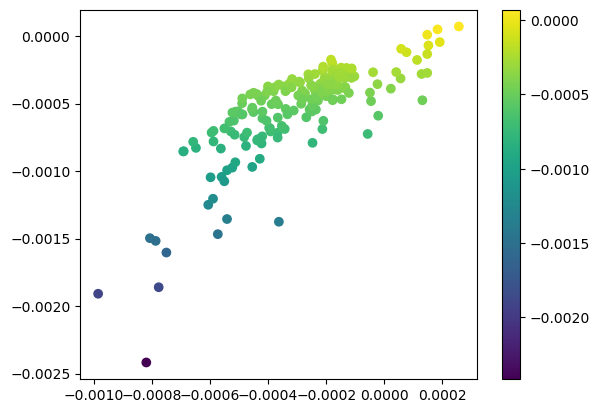

In [69]:
plt.scatter(a.SX,a.SY,c=a.SY)
plt.colorbar()

## Collocation points and auxiliary vectors

In [70]:
## Collocation points for PDF
# vamos a imponerla en toda la región 3D
min_X=final_data["X"].min()
max_X=final_data["X"].max()

min_Y=final_data["Y"].min()
max_Y=final_data["Y"].max()

min_Z=final_data["Z"].min()
max_Z=final_data["Z"].max()

Pos_min = torch.tensor([min_X, min_Y, min_Z])
Pos_max = torch.tensor([max_X, max_Y, max_Z])


num_coloc_points_x=60
num_coloc_points_y=60
num_coloc_points_z=60

X_coloc = np.random.uniform(min_X, max_X, (num_coloc_points_x, 1))
Y_coloc = np.random.uniform(min_Y, max_Y, (num_coloc_points_y, 1))
Z_coloc = np.random.uniform(min_Z, max_Z, (num_coloc_points_z, 1))
comb_array = np.array(np.meshgrid(X_coloc, Y_coloc,Z_coloc)).T.reshape(-1, 3)           # Combine the two arrays
train_coloc = torch.tensor(comb_array,requires_grad=True).to(device)                         # Convert to tensor the collocation points

train_coloc.shape

torch.Size([216000, 3])

In [71]:
# Collocation point for BC
# estos son los puntos donde obligaré a que haya una TENSION concreta, la cual viene determinada por las fuerzas nodales aplicadas

# se están aplicando fuerzas en algunos nodos con limitaciones, esto no debería influir, pues si el desplazamiento es nulo, tambien la tension.  
# aunque la tensión real que aparece ahi no es nula 
nodos_with_force_data=final_data.loc[final_data.apply(lambda x : (not np.isnan(x.Fuerza)) & (not np.isnan(x.SY)),axis=1),["X","Y","Z","SY"]]
nodos_with_force_data

,X,Y,Z,SY
Node,,,,
6.0,27.108,57.070,47.311,-0.000707
181.0,26.161,50.981,29.122,-0.000045
182.0,26.443,50.288,27.876,-0.000281
183.0,27.980,49.724,25.295,-0.000725
184.0,27.784,49.479,25.129,-0.001375
...,...,...,...,...
1213.0,39.288,58.288,45.709,-0.000374
1214.0,42.720,58.336,45.498,-0.000315
1215.0,46.066,58.293,46.134,-0.000355


Estan poniendo como condición de contorno un stress. Es decir, que estamos dividiendo la fuerza aplicada por la superficie de aplicación para así tener una presión, que será el esfuerzo sobre cada nodo. Si por el contrario, aplicamos una fuerza sobre cada nodo de X newtons, lo que necesitamos en teoria es o la tension o la fuerza por volumen, tengo que aclararme con esto.   



In [72]:
# Por último. las condiciones de Dirichlet para la data  
# para los puntos totalmente quietos, los metemos todos, para los de una sola dirección, tambien metemos todos los de esa dirección
# y para el resto, metemos unos cuantos en temas de desplazamientos
# en lo que se limita solo una direcciones, podemos meter la limitación ahi de TODOS, pero del resto no 

data_BC_fix3=final_data.loc[final_data.apply(lambda x : len(x["Restricciones"])==3 if isinstance(x["Restricciones"], list) else False ,axis=1),["X","Y","Z","UX","UY","UZ"]]
data_BC_fix1_Y=final_data.loc[final_data.apply(lambda x : len(x["Restricciones"])==1 if isinstance(x["Restricciones"], list) else False ,axis=1),["X","Y","Z","UX","UY","UZ"]]
data_BC_fix3

,X,Y,Z,UX,UY,UZ
Node,,,,,,
58.0,19.605,32.193,40.349,0.0,0.0,0.0
173.0,19.692,50.419,40.542,0.0,0.0,0.0
174.0,20.263,50.465,39.107,0.0,0.0,0.0
175.0,21.075,50.964,38.226,0.0,0.0,0.0
176.0,21.767,51.016,36.943,0.0,0.0,0.0
...,...,...,...,...,...,...
3255.0,26.440,39.451,32.270,0.0,0.0,0.0
3263.0,53.808,44.100,29.981,0.0,0.0,0.0
3264.0,54.269,45.010,26.763,0.0,0.0,0.0


In [73]:
not_limited_nodes_data=final_data.loc[final_data.apply(lambda x : np.isnan(x["Restricciones"]) if not isinstance(x["Restricciones"], list) else False ,axis=1),["X","Y","Z","UX","UY","UZ"]]
not_limited_nodes_data

,X,Y,Z,UX,UY,UZ
Node,,,,,,
1.0,46.726,41.840,17.459,0.076719,-0.329060,-0.103990
2.0,31.149,44.342,17.410,-0.063502,-0.388420,-0.136950
4.0,63.720,39.982,42.026,0.042579,-0.043482,-0.019361
5.0,19.543,50.820,41.746,-0.028556,-0.089468,0.050299
6.0,27.108,57.070,47.311,-0.004515,-0.531110,0.127660
...,...,...,...,...,...,...
4147.0,47.957,36.969,40.653,0.045424,-0.128460,0.076083
4148.0,43.244,36.666,35.819,0.019351,-0.151880,0.041223
4149.0,46.140,37.853,37.430,0.031225,-0.150200,0.054370


In [74]:
notlimited_traindata=not_limited_nodes_data.sample(frac=0.8,axis=0)
notlimited_testdata=not_limited_nodes_data.loc[[i not in notlimited_traindata.index for i in not_limited_nodes_data.index]]
notlimited_traindata

,X,Y,Z,UX,UY,UZ
Node,,,,,,
3662.0,51.781,46.940,47.812,0.083522,-0.259310,0.148330
3600.0,38.153,29.926,29.579,-0.000433,-0.060799,0.020331
319.0,63.556,44.831,47.343,0.092075,-0.117460,0.017848
2790.0,24.325,33.040,49.124,-0.088194,-0.116390,0.062737
1046.0,37.612,57.346,41.868,0.012260,-0.657790,0.073868
...,...,...,...,...,...,...
3081.0,41.155,53.741,46.390,-0.000664,-0.494910,0.178450
1634.0,22.614,32.772,52.410,-0.105270,-0.149490,0.054596
4092.0,34.842,35.325,45.012,-0.025085,-0.132710,0.114320


In [75]:
#px.scatter_3d(not_limited_nodes_data,x="X",y="Y",z="Z",color="UX")


Los datos que usaremos para entrenar sera el 70% de los datos no limitados + los datos limitados en 1 y 3 direcciones.  
Y validaremos con los datos del 30% no limitados.  

In [76]:
train_data=pd.concat([notlimited_traindata,data_BC_fix3,data_BC_fix1_Y])
train_data=train_data.sample(frac=1)
train_data

,X,Y,Z,UX,UY,UZ
Node,,,,,,
4075.0,27.620,36.119,43.456,-0.055701,-0.109840,0.072163
2882.0,37.074,30.894,22.936,-0.018588,-0.150790,-0.027607
1600.0,43.753,36.872,59.758,0.043907,-0.184230,0.183700
1963.0,30.366,30.319,30.236,-0.029366,-0.053539,0.012884
23.0,27.451,25.543,50.376,-0.032200,0.000000,0.073012
...,...,...,...,...,...,...
2941.0,22.043,47.176,50.298,-0.105530,-0.230050,0.122230
1691.0,34.307,38.419,40.114,-0.023238,-0.182050,0.080644
507.0,41.689,32.072,18.670,0.020697,-0.244060,-0.046555


In [77]:
xyz_train=torch.tensor(train_data[["X","Y","Z"]].values,requires_grad=True).to(torch.float32).to(device)
uvw_train=torch.tensor(train_data[["UX","UY","UZ"]].values,requires_grad=True).to(torch.float32).to(device)

xyz_bc_train=torch.tensor(nodos_with_force_data[["X","Y","Z"]].values,requires_grad=True).to(torch.float32).to(device)
sigma_bc_train=torch.tensor(nodos_with_force_data["SY"].values,requires_grad=True).to(torch.float32).to(device).view(-1,1)


In [78]:
xyz_test=torch.tensor(notlimited_testdata[["X","Y","Z"]].values,requires_grad=True).to(torch.float32).to(device)
uvw_test=torch.tensor(notlimited_testdata[["UX","UY","UZ"]].values,requires_grad=True).to(torch.float32).to(device)


In [79]:
print(xyz_train.shape,uvw_train.shape,xyz_bc_train.shape,sigma_bc_train.shape,xyz_test.shape)

torch.Size([3452, 3]) torch.Size([3452, 3]) torch.Size([193, 3]) torch.Size([193, 1]) torch.Size([699, 3])


Resumen, tenemos por un lado la physic loss que serán en muchos puntos por todo el dominio.  
En los puntos de fuerzas aplicadas, tendremos las BC loss.  
En los puntos con restricciones tendremos todos los puntos disponibles, y si la restricciones e unidireccional, pues en esa dirección. Y sumada a esta, las loss de la data.  

## Deep NN class

In [80]:
#  Deep Neural Network
class DNN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        self.layers=layers
        'activation function'
        self.activation = nn.Tanh()
    
        'Initialize neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
    
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
              
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)             

        xn = normalize(x, Pos_min, Pos_max)         # Normalize the input

        #convert to float
        a = xn.float()

        # inpunt and hidden layers forward computation
        for i in range(len(self.layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)

        # output layer forward computation            
        a = self.linears[-1](a)
        
        return a

## PINN class

In [81]:
class PINN:
    def __init__(self, layers):
        
        'Define loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialize iterator'
        self.iter = 0
        
        # 'Initialize our new parameter G, N, ec, eg as tensor (Inverse problem)' 
        # self.G = torch.tensor([float(G_init)], requires_grad=True).float().to(device)  
                
        # 'Register parametes to be optimized'
        # self.G = nn.Parameter(self.G)

        'Initialize our DNN'
        self.dnn = DNN(layers).to(device)
        
        # 'Register our new parameter'
        # self.dnn.register_parameter('G', self.G)  

        'History of losses'
        self.loss_history = {"Data": [],
                             "PDE": [],
                             "BC": [],
                             "Total":[]}
        
        # 'Parameters trials'
        # self.params_history = {"G": [] }

    def loss_data(self, x, u_real, save = False):
        #aqui están las restricciones de movimiento tanto de xyz como las de y solo
        #estamo suponiendo que eso es suficiente para que la red lo aprenda
        #le estamos metiendo todos los nodos que están quietos, y también le vamos a meter
        #todos los que solo se pueden desplazar en dos direcciones, 

        #esta pendiente, en estos con una restriccion en una sola dirección, calcular la loss
        #SOLO en esa direccion 

        
        u_nn = self.dnn(x)
     
        loss_d = self.loss_function(u_nn, u_real)
        
        save and self.loss_history["Data"].append(loss_d.to('cpu').detach().numpy()) 
        
        return loss_d
        
    def loss_PDE(self, pos_f, save = False):
                       
        # clone the input data and add AD
       
        pos = pos_f.clone().to(torch.float32)
        #pos.requires_grad = True

        # predict u
        U = self.dnn(pos)

        #primeras derivadas 

        dU = autograd.grad(U, pos, torch.ones([pos.shape[0], 3]).to(device),retain_graph=True, create_graph=True)[0]

        # u_x = dU[:,0].reshape(-1,1)
        # v_y = dU[:,1].reshape(-1,1)
        # w_z = dU[:,2].reshape(-1,1)

        U_shifted1 = torch.roll(U, 1, 1)
        dU_1 = autograd.grad(U_shifted1, pos, torch.ones([pos.shape[0], 3]).to(device),retain_graph=True, create_graph=True)[0]

        # w_x = dU_1[:,0].reshape(-1,1)
        # u_y = dU_1[:,1].reshape(-1,1)
        # v_z = dU_1[:,2].reshape(-1,1)

        U_shifted2 = torch.roll(U, 1, 1)
        dU_2 = autograd.grad(U_shifted2, pos, torch.ones([pos.shape[0], 3]).to(device),retain_graph=True, create_graph=True)[0]

        # v_x = dU_2[:,0].reshape(-1,1)
        # w_y = dU_2[:,1].reshape(-1,1)
        # u_z = dU_2[:,2].reshape(-1,1)
        
        # second derivatives

        ddU = autograd.grad(dU, pos, torch.ones([pos.shape[0], 3]).to(device),retain_graph=True, create_graph=True)[0]

        u_xx = ddU[:,0].reshape(-1,1)
        v_yy = ddU[:,1].reshape(-1,1)
        w_zz = ddU[:,2].reshape(-1,1)

        ddU_1 = autograd.grad(dU_1, pos, torch.ones([pos.shape[0], 3]).to(device),retain_graph=True, create_graph=True)[0]

        w_xx = ddU_1[:,0].reshape(-1,1)
        u_yy = ddU_1[:,1].reshape(-1,1)
        v_zz = ddU_1[:,2].reshape(-1,1)

        ddU_2 = autograd.grad(dU_2, pos, torch.ones([pos.shape[0], 3]).to(device),retain_graph=True, create_graph=True)[0]

        v_xx = ddU_2[:,0].reshape(-1,1)
        w_yy = ddU_2[:,1].reshape(-1,1)
        u_zz = ddU_2[:,2].reshape(-1,1)


        # Shift columns of du tensor
        dU_shifted = torch.roll(dU, 1, 1)

        cross_ddU_1 = autograd.grad(dU_shifted, pos, torch.ones([pos.shape[0], 3]).to(device),retain_graph=True, create_graph=True)[0]

        w_xz = cross_ddU_1[:,0].reshape(-1,1)
        u_yx = cross_ddU_1[:,1].reshape(-1,1)
        v_zy = cross_ddU_1[:,2].reshape(-1,1)

        cross_ddU_2 = autograd.grad(dU_shifted, pos, torch.ones([pos.shape[0], 3]).to(device),retain_graph=True, create_graph=True)[0]

        v_xy = cross_ddU_2[:,0].reshape(-1,1)
        w_yz = cross_ddU_2[:,1].reshape(-1,1)
        u_zx = cross_ddU_2[:,2].reshape(-1,1)


        # PDE f = 0
        # f = [ (2*G)/(1-nu) * (u_xx + nu*v_yx) + G*(u_xy+ v_yy) ,  
        #       G*(u_xx + v_yx) + (2*G)/(1-nu)*(v_yy + nu*u_xy) ]
        # f_tensor= torch.cat((f[0] , f[1]), dim=1).to(torch.float32)

        f = [(u_xx+u_yy+u_zz) + (1)/(1-2*nu)*(u_xx + v_xy + w_xz),
             (v_xx+v_yy+v_zz) + (1)/(1-2*nu)*(u_yx + v_yy + w_yz),
             (w_xx+w_yy+w_zz) + (1)/(1-2*nu)*(u_zx + v_zy + w_zz) ]

        f_tensor= torch.cat((f[0] , f[1],f[2]), dim=1).to(torch.float32).to(device)
        
        # f_hat is just an auxiliar term to copmute the loss (is zero)
        loss_f = self.loss_function(f_tensor, torch.zeros_like(f_tensor).to(torch.float32).to(device) )

        save and self.loss_history["PDE"].append(loss_f.to('cpu').detach().numpy()) 
        return loss_f


    def loss_BC(self, pos_bc,sigma_bc, save = False):
        #nuestras condiciones serán hacer que en los nodos donde se aplica la fuerza, las tensiones 
        #sean las registradas para la dirección en la que se aplican, -Y
        
        # clone the input data and add AD
        pos = pos_bc.clone().to(torch.float32)
        #pos.requires_grad = True
        
        # predict U
        U = self.dnn(pos)
        
        # compute the derivatives togheter
        dU = autograd.grad(U, pos, torch.ones([pos.shape[0], 3]).to(device), retain_graph=True, create_graph=True)[0]
        u_x = dU[:,0].reshape(-1,1)
        v_y = dU[:,1].reshape(-1,1)
        w_z = dU[:,2].reshape(-1,1)

        # compute s22_pred ESTO TENGO PENDIENTE HACERLO MEJOR PARA CUALQUIER DIRECCION
        s22_pred = E/((1+nu)*(1-2*nu)) * ((1-nu)*u_x + nu*v_y+nu+w_z)

        loss_bc = self.loss_function(s22_pred.to(torch.float32), sigma_bc.to(torch.float32))
        
        save and self.loss_history["BC"].append(loss_bc.to('cpu').detach().numpy()) 

        return loss_bc


    def loss(self, pos_real, despl_real, pos_f, pos_bc,sigma_bc, save = False):

        loss_d  = self.loss_data(pos_real, despl_real, save)
        loss_f  = self.loss_PDE( pos_f, save)
        loss_bc = self.loss_BC(pos_bc,sigma_bc, save)
        
        # weights should sum 1
        #valores_aux=np.array([loss_f.to('cpu').detach().numpy().item(),loss_d.to('cpu').detach().numpy().item(),loss_bc.to('cpu').detach().numpy().item()])
        loss_val =loss_d  + 1e8*loss_f +1e3*loss_bc

        if save:
            self.loss_history["Total"].append(loss_val.to('cpu').detach().numpy())
        return loss_val


    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss = self.loss(xyz_train, uvw_train, train_coloc, xyz_bc_train,sigma_bc_train, True).to(torch.float32)
        loss.backward()
        
        self.iter += 1

        print(
            'LBFGS iter: %d, Loss error(Train): %.10f ' %
            (   
                self.iter,
                loss.cpu().detach().numpy(),
            )
        )

        
        return loss        
    
    'foward pass'
    def forward(self,pos):
        return self.dnn(pos)

In [82]:
np.array([2,3,6]).max().item()

6

In [83]:
'Neural Network Summary'
layers=[3,20,40,20,20,3]
pinn_LBFGS = PINN(layers)

'Neural Network Parameters'
params = list(pinn_LBFGS.dnn.parameters())

'Mesure time'
start_time = time.time()

'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(params, lr, 
                              max_iter = 1000, 
                              max_eval = None, 
                              tolerance_grad = 1e-7, 
                              tolerance_change = 1e-7, 
                              line_search_fn = 'strong_wolfe',
                              history_size = 100)

optimizer.step(pinn_LBFGS.closure)

elapsed_time_LBFGS = time.time() - start_time
print('Elapsed time: %.10f seconds.' % elapsed_time_LBFGS)

LBFGS iter: 1, Loss error(Train): 123.1577835083 
LBFGS iter: 2, Loss error(Train): 122.3969497681 
LBFGS iter: 3, Loss error(Train): 119.0268554688 
LBFGS iter: 4, Loss error(Train): 87.9060821533 
LBFGS iter: 5, Loss error(Train): 86.9071884155 
LBFGS iter: 6, Loss error(Train): 82.5023422241 
LBFGS iter: 7, Loss error(Train): 43.7645149231 
LBFGS iter: 8, Loss error(Train): 43.1204681396 
LBFGS iter: 9, Loss error(Train): 40.2923507690 
LBFGS iter: 10, Loss error(Train): 16.8420600891 
LBFGS iter: 11, Loss error(Train): 16.6194248199 
LBFGS iter: 12, Loss error(Train): 15.6427078247 
LBFGS iter: 13, Loss error(Train): 7.7277975082 
LBFGS iter: 14, Loss error(Train): 7.6638340950 
LBFGS iter: 15, Loss error(Train): 7.1167249680 
LBFGS iter: 16, Loss error(Train): 4.4840993881 
LBFGS iter: 17, Loss error(Train): 4.4788441658 
LBFGS iter: 18, Loss error(Train): 4.4556627274 
LBFGS iter: 19, Loss error(Train): 4.2545952797 
LBFGS iter: 20, Loss error(Train): 4.2498965263 
LBFGS iter: 21

KeyboardInterrupt: 

In [84]:

U = pinn_LBFGS.forward(xyz_test)

# # convert U[:,0] and U[:,1] to numpy arrays
# u = U[:,0].cpu().detach().numpy()
# v = U[:,1].cpu().detach().numpy()

# # plot  u and v
# plt.plot(u, label='u')
# plt.plot(v, label='v')
# plt.legend()
# plt.show()


In [85]:
pred_u_df=pd.DataFrame(U.cpu().detach().numpy(),columns=["U_pred","V_pred","W_pred"],index=notlimited_testdata.index)

In [86]:
pd.concat([notlimited_testdata])

,X,Y,Z,UX,UY,UZ
Node,,,,,,
5.0,19.543,50.820,41.746,-0.028556,-0.089468,0.050299
10.0,46.169,56.619,52.452,0.007441,-0.356630,0.166710
11.0,20.637,48.231,53.115,-0.117940,-0.239380,0.122270
13.0,26.614,42.682,55.636,-0.109240,-0.236970,0.153970
15.0,28.209,42.906,56.017,-0.095920,-0.237150,0.170190
...,...,...,...,...,...,...
4136.0,39.177,40.628,34.756,0.003455,-0.246920,0.021658
4145.0,37.774,42.295,47.836,-0.007387,-0.262370,0.178570
4146.0,35.185,44.025,47.044,-0.026084,-0.294860,0.176530


In [87]:
pred_final=pd.concat([notlimited_testdata,pred_u_df],axis=1)
pred_final

,X,Y,Z,UX,UY,UZ,U_pred,V_pred,W_pred
Node,,,,,,,,,
5.0,19.543,50.820,41.746,-0.028556,-0.089468,0.050299,0.064858,-0.400004,0.232065
10.0,46.169,56.619,52.452,0.007441,-0.356630,0.166710,-0.050262,-0.325453,0.064104
11.0,20.637,48.231,53.115,-0.117940,-0.239380,0.122270,-0.070715,-0.487383,0.194443
13.0,26.614,42.682,55.636,-0.109240,-0.236970,0.153970,-0.146783,-0.458865,0.106456
15.0,28.209,42.906,56.017,-0.095920,-0.237150,0.170190,-0.152224,-0.452156,0.095516
...,...,...,...,...,...,...,...,...,...
4136.0,39.177,40.628,34.756,0.003455,-0.246920,0.021658,0.045002,-0.173055,0.007466
4145.0,37.774,42.295,47.836,-0.007387,-0.262370,0.178570,-0.087525,-0.309824,0.024327
4146.0,35.185,44.025,47.044,-0.026084,-0.294860,0.176530,-0.063030,-0.326170,0.059141


In [88]:
rel_error_U=((U-uvw_test)/uvw_test).cpu().detach().numpy()
ee_rel_error=rel_error_U[:,0]**2+rel_error_U[:,1]**2+rel_error_U[:,2]**2

In [89]:
pred_final["rel_error"]=ee_rel_error
pred_final

,X,Y,Z,UX,UY,UZ,U_pred,V_pred,W_pred,rel_error
Node,,,,,,,,,,
5.0,19.543,50.820,41.746,-0.028556,-0.089468,0.050299,0.064858,-0.400004,0.232065,35.807320
10.0,46.169,56.619,52.452,0.007441,-0.356630,0.166710,-0.050262,-0.325453,0.064104,60.526051
11.0,20.637,48.231,53.115,-0.117940,-0.239380,0.122270,-0.070715,-0.487383,0.194443,1.582094
13.0,26.614,42.682,55.636,-0.109240,-0.236970,0.153970,-0.146783,-0.458865,0.106456,1.090160
15.0,28.209,42.906,56.017,-0.095920,-0.237150,0.170190,-0.152224,-0.452156,0.095516,1.359040
...,...,...,...,...,...,...,...,...,...,...
4136.0,39.177,40.628,34.756,0.003455,-0.246920,0.021658,0.045002,-0.173055,0.007466,145.143082
4145.0,37.774,42.295,47.836,-0.007387,-0.262370,0.178570,-0.087525,-0.309824,0.024327,118.462730
4146.0,35.185,44.025,47.044,-0.026084,-0.294860,0.176530,-0.063030,-0.326170,0.059141,2.459766


(-5.0, 5.0)

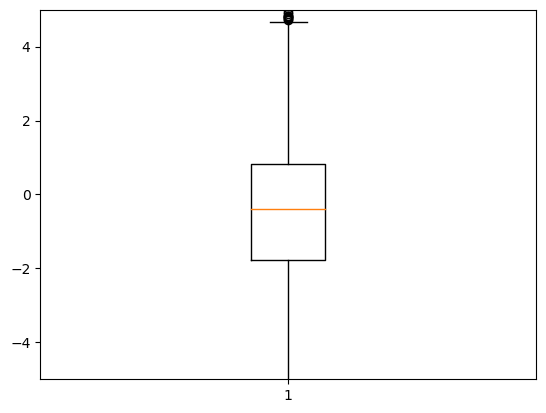

In [90]:
plt.boxplot(rel_error_U.flatten())
plt.ylim(-5,5)

In [91]:
pred_final.loc[pred_final["rel_error"]<0.01]

,X,Y,Z,UX,UY,UZ,U_pred,V_pred,W_pred,rel_error
Node,,,,,,,,,,


In [92]:
pred_final.loc[pred_final["rel_error"]>1]

,X,Y,Z,UX,UY,UZ,U_pred,V_pred,W_pred,rel_error
Node,,,,,,,,,,
5.0,19.543,50.820,41.746,-0.028556,-0.089468,0.050299,0.064858,-0.400004,0.232065,35.807320
10.0,46.169,56.619,52.452,0.007441,-0.356630,0.166710,-0.050262,-0.325453,0.064104,60.526051
11.0,20.637,48.231,53.115,-0.117940,-0.239380,0.122270,-0.070715,-0.487383,0.194443,1.582094
13.0,26.614,42.682,55.636,-0.109240,-0.236970,0.153970,-0.146783,-0.458865,0.106456,1.090160
15.0,28.209,42.906,56.017,-0.095920,-0.237150,0.170190,-0.152224,-0.452156,0.095516,1.359040
...,...,...,...,...,...,...,...,...,...,...
4136.0,39.177,40.628,34.756,0.003455,-0.246920,0.021658,0.045002,-0.173055,0.007466,145.143082
4145.0,37.774,42.295,47.836,-0.007387,-0.262370,0.178570,-0.087525,-0.309824,0.024327,118.462730
4146.0,35.185,44.025,47.044,-0.026084,-0.294860,0.176530,-0.063030,-0.326170,0.059141,2.459766


In [93]:
import plotly.graph_objects as go

fig = go.Figure()

# Agregar los puntos con rel_error < 1
fig.add_trace(go.Scatter3d(
    x=pred_final.loc[pred_final["rel_error"] < 1]["X"],
    y=pred_final.loc[pred_final["rel_error"] < 1]["Y"],
    z=pred_final.loc[pred_final["rel_error"] < 1]["Z"],
    mode='markers',
    marker=dict(
        color=pred_final.loc[pred_final["rel_error"] < 1]["rel_error"],
        colorscale='Viridis',
        size=5,
        colorbar=dict(
            title='Rel_error',
            titleside='right',
            tickmode='auto',
            ticks='outside',
            tickcolor='white',
            ticklen=5,
            showticksuffix='last',
            thickness=20
        )
    ),
    name='Rel_error < 1'
))

# Agregar los puntos con rel_error > 1
fig.add_trace(go.Scatter3d(
    x=pred_final.loc[pred_final["rel_error"] > 1]["X"],
    y=pred_final.loc[pred_final["rel_error"] > 1]["Y"],
    z=pred_final.loc[pred_final["rel_error"] > 1]["Z"],
    mode='markers',
    marker=dict(
        color='grey',
        opacity=0.5,
        size=5
    ),
    name='Rel_error > 1'
))

# Actualizar el diseño del gráfico
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z'
))

# Mostrar el gráfico
fig.show()


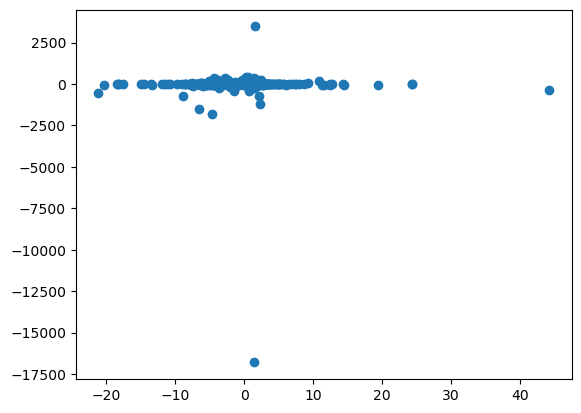

In [47]:
plt.scatter(rel_error_U[:,1],rel_error_U[:,0])

## Verification

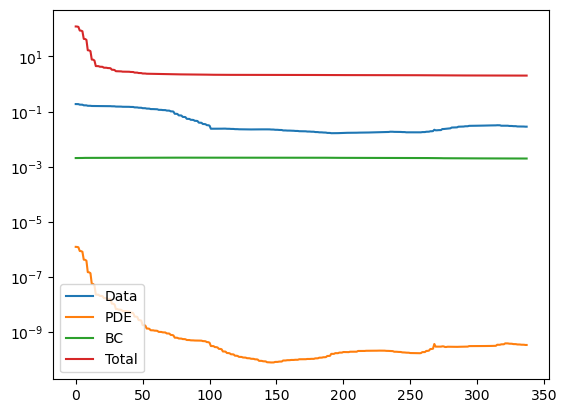

<Figure size 640x480 with 0 Axes>

In [94]:
# print los history with log scale
plt.plot(pinn_LBFGS.loss_history["Data"], label='Data')
plt.plot(pinn_LBFGS.loss_history["PDE"], label='PDE')
plt.plot(pinn_LBFGS.loss_history["BC"], label='BC')
plt.plot(pinn_LBFGS.loss_history["Total"], label='Total')
plt.yscale('log')
plt.legend()
plt.show()
plt.savefig('PINN_LEP_Losses.png')